# INF554 - Machine and Deep Learning
## Lab 7 - Regularization

The following code loads and visualizes some data for classification. We will reapproach logistic regression with stochastic gradient descent, however this time we will pay closer attention to aspects of regularization.

In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder

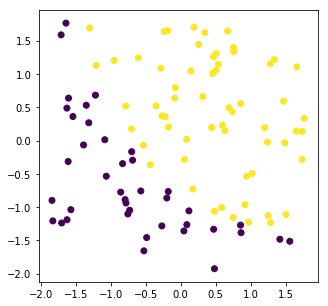

In [3]:
D = np.loadtxt("./data/data.csv",delimiter=',')
X = D[:,:2]
X -= X.mean(0)
X /= X.std(0) + 1e-5
Y = D[:,-1]
# X, Y = make_blobs(n_samples=500, n_features=2, centers=2)
X_min = X.min()
X_max = X.max()
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

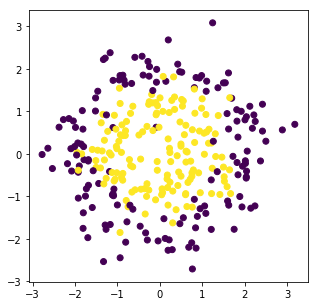

In [4]:
def get_circle(r=1.0, N=100):  
    # Use polar coords to get unif dist points  
    step = np.pi * 2.0 / N  
    t = np.arange(0, np.pi * 2.0, step)  
    x_1 = r * np.cos(t)  
    x_2 = r * np.sin(t)  
    return np.column_stack((x_1, x_2))
      
def get_noise(stddev=0.4, N=100):  
    # 2d gaussian random noise  
    x_1 = np.random.normal(0, stddev, N)  
    x_2 = np.random.normal(0, stddev, N)  
    return np.column_stack((x_1, x_2))    
  
def generateData(N=100,shuffle=True):
    X = np.vstack([get_circle(r=1,N=N//2) + get_noise(N=N//2), get_circle(r=2,N=N//2) + get_noise(N=N//2)])
    Y = np.vstack([np.ones((N//2,1)),np.zeros((N//2,1))]).squeeze().astype(np.int)
    if shuffle:
        p=np.random.permutation(N)
        X = X[p]
        Y = Y[p]
        
    return X,Y 

X, Y = generateData(N=300,shuffle=True)
X_min = X.min()
X_max = X.max()

n,d = X.shape
k = 2
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=Y)
plt.show()

### 1. Polynomial Logistic Regression

We will construct features from polynomials of the original features. For example, the feature space
of polynomial terms of some $x = \left[x1, x2\right]$ up to the sixth degree:
\begin{equation}
\Phi_6(x) = \left[1, x_1, x_2, x_1^2, x_1x_2, x_2^2, x_1^3, \ldots, x_1x_2^5, x_2^6\right]
\end{equation}

As a result of this mapping, our feature vector has been transformed into a 28-dimensional vector.
A logistic regression classifier trained on this higher-dimension feature vector will have a more complex
(non-linear) decision boundary with respect to the original feature space.



### Task 1
Implement the feature map

In [5]:
def FeatureMap(X,degree=1):
    Xpol = X.copy()
    
    res = [X.copy()]
    
    for i in range(1,degree):
        Xpol = Xpol[:, :, np.newaxis] * X[:, np.newaxis, :]
        Xpol = Xpol.reshape((Xpol.shape[0],-1))
        res.append(Xpol)
    feat = np.hstack(res)
    return feat

def AddIntercept(X):
    return np.vstack([X.T,np.ones(X.shape[0]).T]).T


### Regularized Logistic Regression

We define the error (cost) function as the negative log-likelihood:
\begin{equation}
J\left(θ\right) = - \frac{1}{m}\sum_{i=1}^m
\left[
    y^{(i)}
    \log\left(
        p_{\theta}\left(
            x^{(i)}
        \right)
    \right)
    +
    \left( 1 - y^{(i)} \right)
    \log\left(
         1 - p_{\theta}\left(
            x^{(i)}
         \right)
    \right)
\right]
+
\frac{\lambda}{2}
\sum_{j=1}^n \theta_j^2
\end{equation}

which includes a penalty term on the weights. The strength of this penalty term is governed by $\lambda$. Note that *we never regularize the bias term $\theta_0$*. 

In [6]:
def sigmoid(x):
    """
    Computes sigmoid of `x` element-wise.
    Specifically, `y = 1 / (1 + exp(-x))`.
    Args:
        x: ndarray
    Returns:
        A ndarray with the same type as `x`.
    """
    epsilon  = 1e-6
    g = 1./(1.+np.exp(-x + epsilon))
    g = np.clip(g, 0.001, 0.999)
    
    return g

In [7]:
def logistic_forward(w, X, logit=True):
    # Predict whether each label is 0 or 1 using learned logistic regression parameters. The threshold is set at 0.5
 
    logits = sigmoid(X@w)
    if not logit:
        return np.round(logits).astype(np.int)
    return logits
     

In [8]:
def cost(X, y, w, lam=0.1): 
    
    # Computes the cost using w as the parameters for logistic regression. 
    epsilon = 1e-5

    N = X.shape[0] # number of examples
    
    h = sigmoid(X@w).squeeze()
    E = (-y * np.log(h + epsilon)) - ((1 - y) * np.log(1 - h + epsilon))

    return E.mean()

In [9]:
def compute_grad( X, y, w , lam=0.1):
    
    # Computes the gradient of the cost with respect to the parameters.
     
    dE = X.T @ (sigmoid(X @ w) - y)

    return dE

### Task 2. 
Extend your implementation of SGD from the Lab 2, to incorporate the $l_2$ penalty
term.

In [10]:
def cost_reg( X, y, w, lam=0.1): 
    
    # Computes the cost using w as the parameters for logistic regression. 
    
    epsilon = 1e-5

    N = X.shape[0] # number of examples
    
    h = sigmoid(X@w).squeeze()
    E = -y * np.log(h+epsilon) - (1 - y) * np.log(1 - h +epsilon)

    #Regularization cost
    E +=  lam * np.sum(w**2) / 2.
        
    return E.mean()

In [11]:
def compute_grad_reg( X, y, w , lam=0.1):
    
    # Computes the gradient of the cost with respect to the parameters.
    N = X.shape[0] # number of examples

    dE = X.T @ (sigmoid(X @ w) - y)
    
    #Regularization cost
    dE[:-1,:] = dE[:-1,:] + ( lam * w[:-1,:]) # indexing avoids penalizing the bias term

    return dE

### Task 3.
Try out different regularization parameters $\lambda$ and polynomial degrees for the available datasets to understand how regularization prevents over-fitting. In particular, you could have a look at the values of the parameters.

### Task 4.
Tune $\lambda$ using $10$-fold cross validation.

In [12]:
N = X.shape[0]

degree = 4
FX = FeatureMap(X,degree)
FXb = AddIntercept(FX)

# Create Splits
kf = KFold(n_splits=5)
kf.get_n_splits(X)
Splits = kf.split(FXb)

#Initialize parameteres
W_init = np.random.randn(FXb.shape[1],1) * 0.5

# Gradient Descent
alpha = 1e-3
n_iterations = 200
lambdas = np.array([ 100, 50, 20, 10, 5, 1, 0.1, 0.01])

lcost_reg=[]
tr_acc_reg = []
te_acc_reg = []

bsize=32

for train_index, test_index in Splits:
    print("#####################")
    print("Testing a new split")
    print("#####################")
    X_train, X_test, Y_train, Y_test = FXb[train_index], FXb[test_index], Y[train_index], Y[test_index]
    
    lcost_reg_f = []
    tr_acc_reg_f = []
    te_acc_reg_f = []
    for lam in lambdas:
        W_reg = W_init.copy()

        print("Checking for lambda {}".format(lam))
        lcost_reg_ = []
        tr_acc_reg_ = []
        te_acc_reg_ = []


        for i in range(n_iterations):
            p = np.random.permutation(X_train.shape[0])
            X_train = X_train[p]
            Y_train = Y_train[p]
            
            for b in range(0, X_train.shape[0],bsize):
                X_train_batch = X_train[b:b+bsize]
                Y_train_batch = Y_train[b:b+bsize]
                lcost_reg_.append(cost_reg(X_train_batch,Y_train_batch,W_reg,lam))

                Y_train_pred = logistic_forward(W_reg,X_train_batch,logit=False).squeeze()
                Y_test_pred = logistic_forward(W_reg,X_test,logit=False).squeeze()
                tr_acc_reg_.append(100*np.sum(Y_train_pred==Y_train_batch)/Y_train_batch.shape[0])
                te_acc_reg_.append(100*np.sum(Y_test_pred==Y_test)/Y_test.shape[0])

                W_reg = W_reg - (alpha * compute_grad_reg(X_train_batch,Y_train_batch.reshape(-1,1), W_reg,lam=lam))
        lcost_reg_f.append(np.array(lcost_reg_))
        tr_acc_reg_f.append(np.array(tr_acc_reg_))
        te_acc_reg_f.append(np.array(te_acc_reg_))

    lcost_reg.append(np.array(lcost_reg_f))
    tr_acc_reg.append(np.array(tr_acc_reg_f))
    te_acc_reg.append(np.array(te_acc_reg_f))

lcost_reg = np.array(lcost_reg)
tr_acc_reg = np.array(tr_acc_reg)
te_acc_reg = np.array(te_acc_reg)
best_lam = np.argmax(te_acc_reg.mean(0)[:,-1])
print(te_acc_reg.mean(0)[:,-1])
print("The best value for $\lambda$ was {} with a test accuracy of {}".format(lambdas[best_lam],te_acc_reg.mean(0)[best_lam,-1]))
# print(te_acc_reg.mean(0)[:,-1])

#####################
Testing a new split
#####################
Checking for lambda 100.0
Checking for lambda 50.0
Checking for lambda 20.0
Checking for lambda 10.0
Checking for lambda 5.0
Checking for lambda 1.0
Checking for lambda 0.1
Checking for lambda 0.01
#####################
Testing a new split
#####################
Checking for lambda 100.0
Checking for lambda 50.0
Checking for lambda 20.0
Checking for lambda 10.0
Checking for lambda 5.0
Checking for lambda 1.0
Checking for lambda 0.1
Checking for lambda 0.01
#####################
Testing a new split
#####################
Checking for lambda 100.0
Checking for lambda 50.0
Checking for lambda 20.0
Checking for lambda 10.0
Checking for lambda 5.0
Checking for lambda 1.0
Checking for lambda 0.1
Checking for lambda 0.01
#####################
Testing a new split
#####################
Checking for lambda 100.0
Checking for lambda 50.0
Checking for lambda 20.0
Checking for lambda 10.0
Checking for lambda 5.0
Checking for lambda 1.0
C

### Task 5.
Plot the error rate vs iterations.

(5, 8, 1600) [1.e+02 5.e+01 2.e+01 1.e+01 5.e+00 1.e+00 1.e-01 1.e-02]


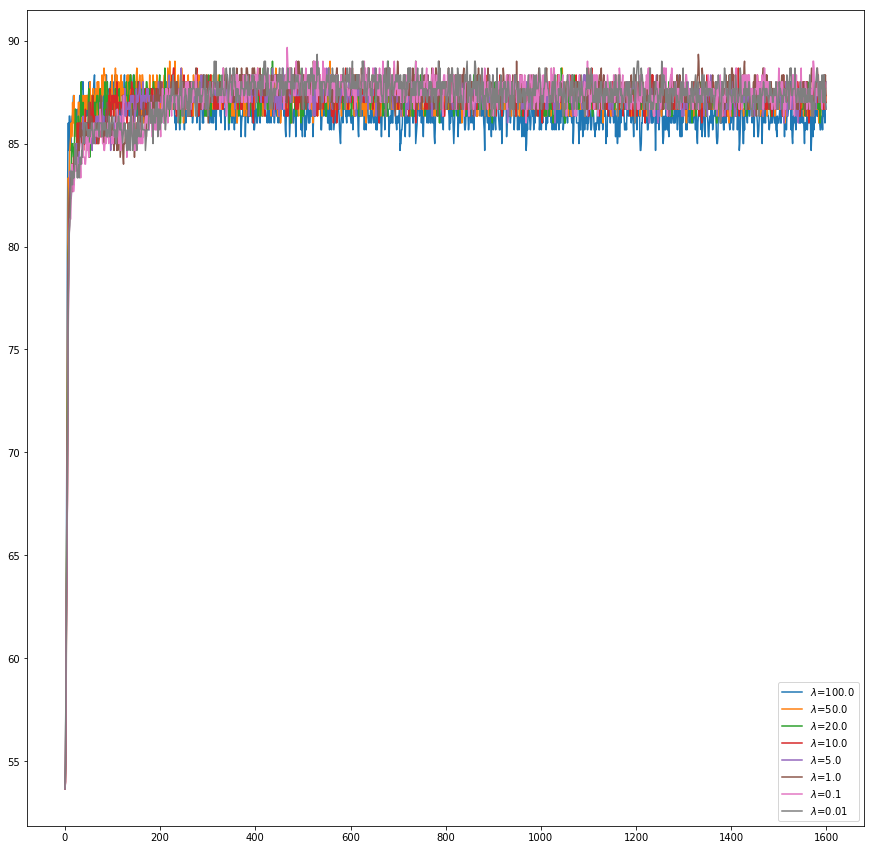

In [13]:
fig = plt.figure(figsize=(15,15))
print(te_acc_reg.shape,lambdas)
for i,lam in enumerate(lambdas):
    plt.plot(te_acc_reg.mean(0)[i,:],label="$\lambda$={:.04}".format(lam))
plt.legend()
plt.show()

### Early Stopping

Split a 20\% validation set off from the training set and compare the coefficients/weights obtained with those under early stopping, wherein, you stop training when the error rate on the test set equals or goes below the error rate of the validation set. At this point, you record the error rate and then retrain the model on the *full* training set until obtaining that error rate.

### Task 6.
Compare vs early stopping and vs no regularization

In [15]:
lcost=[]
tr_acc = []
tr_e_acc = []
tv_e_acc = []
te_e_acc = []
te_acc = []
print("Training with no regularization ")
for train_index, test_index in kf.split(FXb):
    print("#####################")
    print("Testing a new split")
    print("#####################")
    X_train, X_test, Y_train, Y_test = FXb[train_index], FXb[test_index], Y[train_index], Y[test_index]
    X_train_early, X_val_early, Y_train_early, Y_val_early =  train_test_split(X_train, Y_train, random_state=42, test_size=0.2) 
    W = W_init.copy()
    W_early = W_init.copy()
    W_store = None



    lcost_f = []
    tr_acc_f = []
    tr_e_acc_f = []
    te_e_acc_f = []
    tv_e_acc_f = []
    te_acc_f = []


    for i in range(n_iterations):
        p = np.random.permutation(X_train.shape[0])
        X_train = X_train[p]
        Y_train = Y_train[p]
        p = np.random.permutation(X_train_early.shape[0])
        X_train_early = X_train_early[p]
        Y_train_early = Y_train_early[p]

        for b in range(0, X_train.shape[0],bsize):
            X_train_batch = X_train[b:b+bsize]
            Y_train_batch = Y_train[b:b+bsize]
            X_train_batch_early = X_train_early[b:b+bsize]
            Y_train_batch_early = Y_train_early[b:b+bsize]

            lcost_f.append(cost(X_train,Y_train,W))

            tr_acc_f.append(100*np.sum(logistic_forward(W,X_train_batch,logit=False).squeeze()==Y_train_batch)/Y_train_batch.shape[0])
            tr_e_acc_f.append(100*np.sum(logistic_forward(W_early,X_train_batch_early,logit=False).squeeze()==Y_train_batch_early)/Y_train_batch_early.shape[0])
            tv_e_acc_f.append(100*np.sum(logistic_forward(W_early,X_val_early,logit=False).squeeze()==Y_val_early)/Y_val_early.shape[0])
            te_e_acc_f.append(100*np.sum(logistic_forward(W_early,X_test,logit=False).squeeze()==Y_test)/Y_test.shape[0])
            te_acc_f.append(100*np.sum(logistic_forward(W,X_test,logit=False).squeeze()==Y_test)/Y_test.shape[0])

            if (np.array(tv_e_acc_f)[:-1]<tv_e_acc_f[-1]).all():
                W_store = W_early.copy()

            W = W - (alpha * compute_grad(X_train_batch,Y_train_batch.reshape(-1,1), W))
            W_early = W_early - (alpha * compute_grad(X_train_batch_early,Y_train_batch_early.reshape(-1,1), W_early))


    lcost.append(np.array(lcost_f))
    tr_acc.append(np.array(tr_acc_f))
    tr_e_acc.append(np.array(tr_e_acc_f))
    tv_e_acc.append(np.array(tv_e_acc_f))
    te_e_acc.append(np.array(te_e_acc_f))
    te_acc.append(np.array(te_acc_f))

lcost = np.array(lcost)
tr_acc = np.array(tr_acc)
te_acc = np.array(te_acc)
tr_e_acc = np.array(tr_e_acc)
tv_e_acc = np.array(tv_e_acc)
te_e_acc = np.array(te_e_acc)

print("The accuracy with early stopping is {}".format(np.mean([te_e_acc[i,np.argmax(tv_e_acc,1)[i]] for i in range(5)])))
print("The accuracy with no regularization is {}".format(te_acc.mean(0)[-1]))

Training with no regularization 
#####################
Testing a new split
#####################


/Users/gsalha/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in long_scalars


#####################
Testing a new split
#####################
#####################
Testing a new split
#####################
#####################
Testing a new split
#####################
#####################
Testing a new split
#####################
The accuracy with early stopping is 84.99999999999999
The accuracy with no regularization is 87.33333333333334


### Task 7.
Plot the ROC curves resulting from $l_2$-regularization strategy. Hint: An example
with sklearn: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py

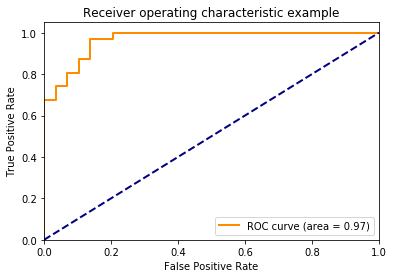

In [47]:
from sklearn.metrics import roc_curve, auc
Y_score = logistic_forward(W_reg,X_test,logit=True)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
# for i in range(n_classes):
fpr[0], tpr[0], _ = roc_curve(1-Y_test, 1-Y_score)
fpr[1], tpr[1], _ = roc_curve(Y_test, Y_score)
roc_auc[0] = auc(fpr[0], tpr[0])
roc_auc[1] = auc(fpr[1], tpr[1])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), Y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### Task 8.
(Bonus): Use Keras to implement Logistic Regression, and use Dropout on the visible layer. Hint: 
```model.add(Dropout(λ, input shape=(2,)))```. 
Experiment with the regularization parameter in the same way as earlier (i.e., using cross validation).

In [39]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import L1L2
from keras.utils import to_categorical

Y_train_one_hot = to_categorical(Y_train)
Y_test_one_hot = to_categorical(Y_test)

scores = []
for lam in lambdas:
    model = None
    model = Sequential()
    model.add(Dense(Y_train_one_hot.shape[1], activation='sigmoid', kernel_regularizer=L1L2(l2=lam)))#, input_shape=X_train.shape))
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


    # Train the model, iterating on the data in batches of 32 samples
    model.fit(X_train, Y_train_one_hot, epochs=100, batch_size=32, verbose=0)
    score = model.evaluate(X_test, Y_test_one_hot, batch_size=128)
    scores.append(score)

for i,lam in enumerate(lambdas):
    print("For lambda = {} the accuracy is {}".format(lam,scores[i][1]))

60/60 [==============================] - 2s 28ms/step
For lambda = 100.0 the accuracy is 0.699999988079071
For lambda = 50.0 the accuracy is 0.875
For lambda = 20.0 the accuracy is 0.8500000238418579
For lambda = 10.0 the accuracy is 0.8500000238418579
For lambda = 5.0 the accuracy is 0.8666666746139526
For lambda = 1.0 the accuracy is 0.875
For lambda = 0.1 the accuracy is 0.8833333253860474
For lambda = 0.01 the accuracy is 0.8916666507720947
